In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import itertools
import logging
import os
import pickle
import pprint
from glob import glob
os.chdir(os.path.expandvars('$HOME/sleep-staging'))

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phate
import scprep
import seaborn as sns
import umap
import umap.plot
from h5py import File

sns.set(context='paper', rc={'figure.figsize':(14,10)})

HYP_DICT = {0: 'W', 1: 'N1', 2: 'N2', 3: 'N3', 4: 'R'}

logging.basicConfig(format='%(asctime)s %(levelname)s | %(message)s', level=logging.INFO, datefmt='%I:%M:%S')
logger = logging.getLogger()

In [3]:
df = pd.read_csv('overview_file_cohortsEM-ling1.csv')
display(df.head())

,Index,ID,ID-ling,Cohort,Diagnosis,Label,Sleep scoring training data,Sleep scoring test data,Narcolepsy training data,Narcolepsy test data,Replication data,High pre-test,CSF hypocretin-1,DQ0602,Added by Alex
0,NaN,SSC_NARCO_1508_1,1508,SSC,'T1 NARCOLEPSY',1,0,1,1,0,0,1,na,1,1
1,NaN,SSC_NARCO_1534_1,1534,SSC,'T1 NARCOLEPSY',1,0,1,1,0,0,1,na,1,1
2,NaN,SSC_NARCO_1538_1,1538,SSC,'T1 NARCOLEPSY',1,0,1,0,1,0,1,na,1,1
3,NaN,SSC_NARCO_1647_1,1647,SSC,'T1 NARCOLEPSY',1,0,1,1,0,0,1,na,1,1
4,1267.0,SSC_1958_1,1958,SSC,'T1 NARCOLEPSY',1,0,1,1,0,0,1,0,0,0


In [4]:
selected_experiment = 'experiments/massc/avg_kw21/20201126_043826/SSC-WSC_test_predictions.pkl'
with open(selected_experiment, 'rb') as f:
    predictions = pickle.load(f)
list_studies = list(predictions.keys())
df_preds = pd.read_csv(os.path.join(os.path.dirname(selected_experiment), 'SSC-WSC_test_results.csv'), index_col=0)
df_preds = pd.merge(left=df_preds, right=df[['ID', 'Diagnosis', 'Label']], how='left', right_on='ID', left_on='SubjectID')
display(df_preds.query('Label == 0').sort_values('Balanced accuracy', ascending=False))
print(f"Unique classes: {df_preds['Diagnosis'].unique()}")
print(f"Window unique classes: {df_preds['Window'].unique()}")
print(f"Case unique classes: {df_preds['Case'].unique()}")
display(df_preds.query('Label == 1'))

,FileID,SubjectID,Window,Case,Accuracy,Balanced accuracy,Kappa,F1,Precision,Recall,...,Precision - N3,Recall - N3,Support - N3,F1 - REM,Precision - REM,Recall - REM,Support - REM,ID,Diagnosis,Label
52,A1038_4 172720.h5,A1038_4 172720,1 s,all,0.849057,0.894873,0.795451,0.830931,0.806470,0.894873,...,0.548148,0.986667,75.0,0.985782,0.971963,1.000000,104.0,A1038_4 172720,'NON-NARCOLEPSY CONTROL',0
508,SSC_6856_1.h5,SSC_6856_1,1 s,all,0.876377,0.892037,0.811801,0.784684,0.733296,0.892037,...,0.480519,1.000000,37.0,0.880000,0.785714,1.000000,33.0,SSC_6856_1,'NON-NARCOLEPSY CONTROL',0
150,C1040_4 181859.h5,C1040_4 181859,1 s,all,0.883333,0.888253,0.817163,0.776490,0.769768,0.888253,...,0.842593,0.900990,101.0,0.973294,0.959064,0.987952,166.0,C1040_4 181859,'NON-NARCOLEPSY CONTROL',0
507,SSC_6854_1.h5,SSC_6854_1,1 s,all,0.831891,0.884168,0.776560,0.818131,0.812352,0.884168,...,0.847134,1.000000,133.0,0.921348,0.901099,0.942529,87.0,SSC_6854_1,'NON-NARCOLEPSY CONTROL',0
220,C9145_2 172540.h5,C9145_2 172540,1 s,all,0.840263,0.883908,0.773819,0.750679,0.725847,0.883908,...,0.407407,1.000000,55.0,0.945736,0.978610,0.915000,200.0,C9145_2 172540,'NON-NARCOLEPSY CONTROL',0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,SSC_5280_1.h5,SSC_5280_1,1 s,all,0.474593,0.530022,0.314027,0.395287,0.529237,0.530022,...,0.940476,0.763285,207.0,0.145631,0.078534,1.000000,15.0,SSC_5280_1,'NON-NARCOLEPSY CONTROL',0
514,SSC_6927_1.h5,SSC_6927_1,1 s,all,0.745384,0.509478,0.571534,0.427622,0.547962,0.407582,...,0.000000,0.000000,0.0,0.907104,0.861592,0.957692,260.0,SSC_6927_1,'NON-NARCOLEPSY CONTROL',0
120,C0605_4 173848.h5,C0605_4 173848,1 s,all,0.544211,0.508400,0.353138,0.490093,0.615286,0.508400,...,0.000000,0.000000,0.0,0.500000,0.774194,0.369231,65.0,C0605_4 173848,'NON-NARCOLEPSY CONTROL',0
411,SSC_5458_1.h5,SSC_5458_1,1 s,all,0.581797,0.489882,0.341106,0.294390,0.314674,0.293929,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,SSC_5458_1,'NON-NARCOLEPSY CONTROL',0


Unique classes: ["'NON-NARCOLEPSY CONTROL'" "'T1 NARCOLEPSY'" "'OTHER HYPERSOMNIA'"]
Window unique classes: ['1 s']
Case unique classes: ['all']


,FileID,SubjectID,Window,Case,Accuracy,Balanced accuracy,Kappa,F1,Precision,Recall,...,Precision - N3,Recall - N3,Support - N3,F1 - REM,Precision - REM,Recall - REM,Support - REM,ID,Diagnosis,Label
299,SSC_1958_1.h5,SSC_1958_1,1 s,all,0.656039,0.700787,0.480362,0.477659,0.486116,0.700787,...,0.292453,0.756098,41.0,0.470588,0.307692,1.000000,16.0,SSC_1958_1,'T1 NARCOLEPSY',1
300,SSC_2605_1.h5,SSC_2605_1,1 s,all,0.681190,0.622985,0.568261,0.466644,0.542127,0.622985,...,0.843836,0.950617,324.0,0.023810,0.012048,1.000000,1.0,SSC_2605_1,'T1 NARCOLEPSY',1
306,SSC_4723_1.h5,SSC_4723_1,1 s,all,0.662694,0.680094,0.549286,0.599497,0.615273,0.680094,...,0.994536,0.719368,253.0,0.896175,0.828283,0.976190,168.0,SSC_4723_1,'T1 NARCOLEPSY',1
315,SSC_4813_1.h5,SSC_4813_1,1 s,all,0.735939,0.597847,0.644742,0.610992,0.633843,0.597847,...,0.000000,0.000000,5.0,0.859756,0.933775,0.796610,177.0,SSC_4813_1,'T1 NARCOLEPSY',1
355,SSC_5139_1.h5,SSC_5139_1,1 s,all,0.649302,0.714275,0.498503,0.585201,0.617166,0.714275,...,0.447619,0.921569,51.0,0.836449,0.736626,0.967568,185.0,SSC_5139_1,'T1 NARCOLEPSY',1
397,SSC_5335_1.h5,SSC_5335_1,1 s,all,0.752821,0.768032,0.678440,0.734077,0.737968,0.768032,...,0.795181,0.985075,134.0,0.759322,0.666667,0.881890,127.0,SSC_5335_1,'T1 NARCOLEPSY',1
499,SSC_6542_1.h5,SSC_6542_1,1 s,all,0.821542,0.879353,0.745264,0.708109,0.721268,0.879353,...,0.920863,0.955224,134.0,0.883168,0.854406,0.913934,244.0,SSC_6542_1,'T1 NARCOLEPSY',1


In [5]:
top10_controls = df_preds[
    (df_preds['Label'] == 0)
    & (df_preds['Support - W'] > 20) 
    & (df_preds['Support - N1'] > 20) 
    & (df_preds['Support - N2'] > 20) 
    & (df_preds['Support - N3'] > 20) 
    & (df_preds["Support - REM"] > 20)
].sort_values(["Accuracy"], ascending=False).head(10).reset_index(drop=True)
display(top10_controls)

,FileID,SubjectID,Window,Case,Accuracy,Balanced accuracy,Kappa,F1,Precision,Recall,...,Precision - N3,Recall - N3,Support - N3,F1 - REM,Precision - REM,Recall - REM,Support - REM,ID,Diagnosis,Label
0,C1584_3 172654.h5,C1584_3 172654,1 s,all,0.912027,0.815213,0.865526,0.784308,0.761220,0.815213,...,0.485714,0.586207,29.0,0.896175,0.872340,0.921348,89.0,C1584_3 172654,'NON-NARCOLEPSY CONTROL',0
1,A2202_3 171828.h5,A2202_3 171828,1 s,all,0.908976,0.836763,0.793684,0.777232,0.766219,0.836763,...,0.705128,1.000000,55.0,0.805970,0.692308,0.964286,28.0,A2202_3 171828,'NON-NARCOLEPSY CONTROL',0
2,A0147_6 165655.h5,A0147_6 165655,1 s,all,0.900966,0.871082,0.842300,0.800551,0.769639,0.871082,...,0.597015,0.851064,47.0,0.938462,0.945736,0.931298,131.0,A0147_6 165655,'NON-NARCOLEPSY CONTROL',0
3,SSC_5547_1.h5,SSC_5547_1,1 s,all,0.899548,0.877883,0.848494,0.850218,0.828665,0.877883,...,0.808383,0.957447,141.0,0.951220,0.917647,0.987342,158.0,SSC_5547_1,'NON-NARCOLEPSY CONTROL',0
4,N4499_2 092211.h5,N4499_2 092211,1 s,all,0.890519,0.819924,0.828192,0.785691,0.766977,0.819924,...,0.702381,0.855072,69.0,0.953930,0.926316,0.983240,179.0,N4499_2 092211,'NON-NARCOLEPSY CONTROL',0
5,A0531_6 175138.h5,A0531_6 175138,1 s,all,0.888331,0.871765,0.843528,0.832315,0.819650,0.871765,...,0.758065,0.824561,57.0,0.928910,0.980000,0.882883,111.0,A0531_6 175138,'NON-NARCOLEPSY CONTROL',0
6,C2209_4 233629.h5,C2209_4 233629,1 s,all,0.888122,0.854197,0.844454,0.833848,0.834242,0.854197,...,0.915254,0.739726,73.0,0.960396,0.960396,0.960396,101.0,C2209_4 233629,'NON-NARCOLEPSY CONTROL',0
7,A1558_4 172739.h5,A1558_4 172739,1 s,all,0.885822,0.711440,0.728961,0.716749,0.761310,0.711440,...,0.727273,0.355556,45.0,0.859259,0.816901,0.906250,64.0,A1558_4 172739,'NON-NARCOLEPSY CONTROL',0
8,C1146_4 182423.h5,C1146_4 182423,1 s,all,0.882547,0.859681,0.821311,0.809713,0.802139,0.859681,...,0.951923,0.811475,122.0,0.893333,0.837500,0.957143,70.0,C1146_4 182423,'NON-NARCOLEPSY CONTROL',0
9,C9188_4 135030.h5,C9188_4 135030,1 s,all,0.881230,0.844254,0.838379,0.792624,0.793171,0.844254,...,0.957317,0.882022,178.0,0.933610,0.925926,0.941423,239.0,C9188_4 135030,'NON-NARCOLEPSY CONTROL',0


In [6]:
narcs = df_preds[
    (df_preds['Label'] == 1)
].sort_values(["Accuracy"], ascending=False).reset_index(drop=True)
display(narcs)

,FileID,SubjectID,Window,Case,Accuracy,Balanced accuracy,Kappa,F1,Precision,Recall,...,Precision - N3,Recall - N3,Support - N3,F1 - REM,Precision - REM,Recall - REM,Support - REM,ID,Diagnosis,Label
0,SSC_6542_1.h5,SSC_6542_1,1 s,all,0.821542,0.879353,0.745264,0.708109,0.721268,0.879353,...,0.920863,0.955224,134.0,0.883168,0.854406,0.913934,244.0,SSC_6542_1,'T1 NARCOLEPSY',1
1,SSC_5335_1.h5,SSC_5335_1,1 s,all,0.752821,0.768032,0.678440,0.734077,0.737968,0.768032,...,0.795181,0.985075,134.0,0.759322,0.666667,0.881890,127.0,SSC_5335_1,'T1 NARCOLEPSY',1
2,SSC_4813_1.h5,SSC_4813_1,1 s,all,0.735939,0.597847,0.644742,0.610992,0.633843,0.597847,...,0.000000,0.000000,5.0,0.859756,0.933775,0.796610,177.0,SSC_4813_1,'T1 NARCOLEPSY',1
3,SSC_2605_1.h5,SSC_2605_1,1 s,all,0.681190,0.622985,0.568261,0.466644,0.542127,0.622985,...,0.843836,0.950617,324.0,0.023810,0.012048,1.000000,1.0,SSC_2605_1,'T1 NARCOLEPSY',1
4,SSC_4723_1.h5,SSC_4723_1,1 s,all,0.662694,0.680094,0.549286,0.599497,0.615273,0.680094,...,0.994536,0.719368,253.0,0.896175,0.828283,0.976190,168.0,SSC_4723_1,'T1 NARCOLEPSY',1
5,SSC_1958_1.h5,SSC_1958_1,1 s,all,0.656039,0.700787,0.480362,0.477659,0.486116,0.700787,...,0.292453,0.756098,41.0,0.470588,0.307692,1.000000,16.0,SSC_1958_1,'T1 NARCOLEPSY',1
6,SSC_5139_1.h5,SSC_5139_1,1 s,all,0.649302,0.714275,0.498503,0.585201,0.617166,0.714275,...,0.447619,0.921569,51.0,0.836449,0.736626,0.967568,185.0,SSC_5139_1,'T1 NARCOLEPSY',1


In [7]:
X = []
y = []
l = []
d = []
for idx, selected_record in top10_controls.iterrows():
    fileid = selected_record['FileID']
    diagnosis = selected_record['Diagnosis'].replace("'", "")
    record = predictions[fileid]
    logits = record['logits']
    target = record['true'].argmax(axis=1).repeat(30)
    labels = np.array([HYP_DICT[t] for t in target])
    labels_disease = [diagnosis for _ in range(len(target))]
    
    X.append(logits)
    y.append(target)
    l.append(labels)
    d.extend(labels_disease)
    
X = np.concatenate(X, axis=0)
y = np.concatenate(y, axis=0)
l = np.concatenate(l, axis=0)

04:42:25 INFO | (0,0): knn=32, min_dist=0.25
04:42:25 INFO | Creating UMAP object
04:42:25 INFO | Fitting UMAP
04:56:45 INFO | Plotting UMAP


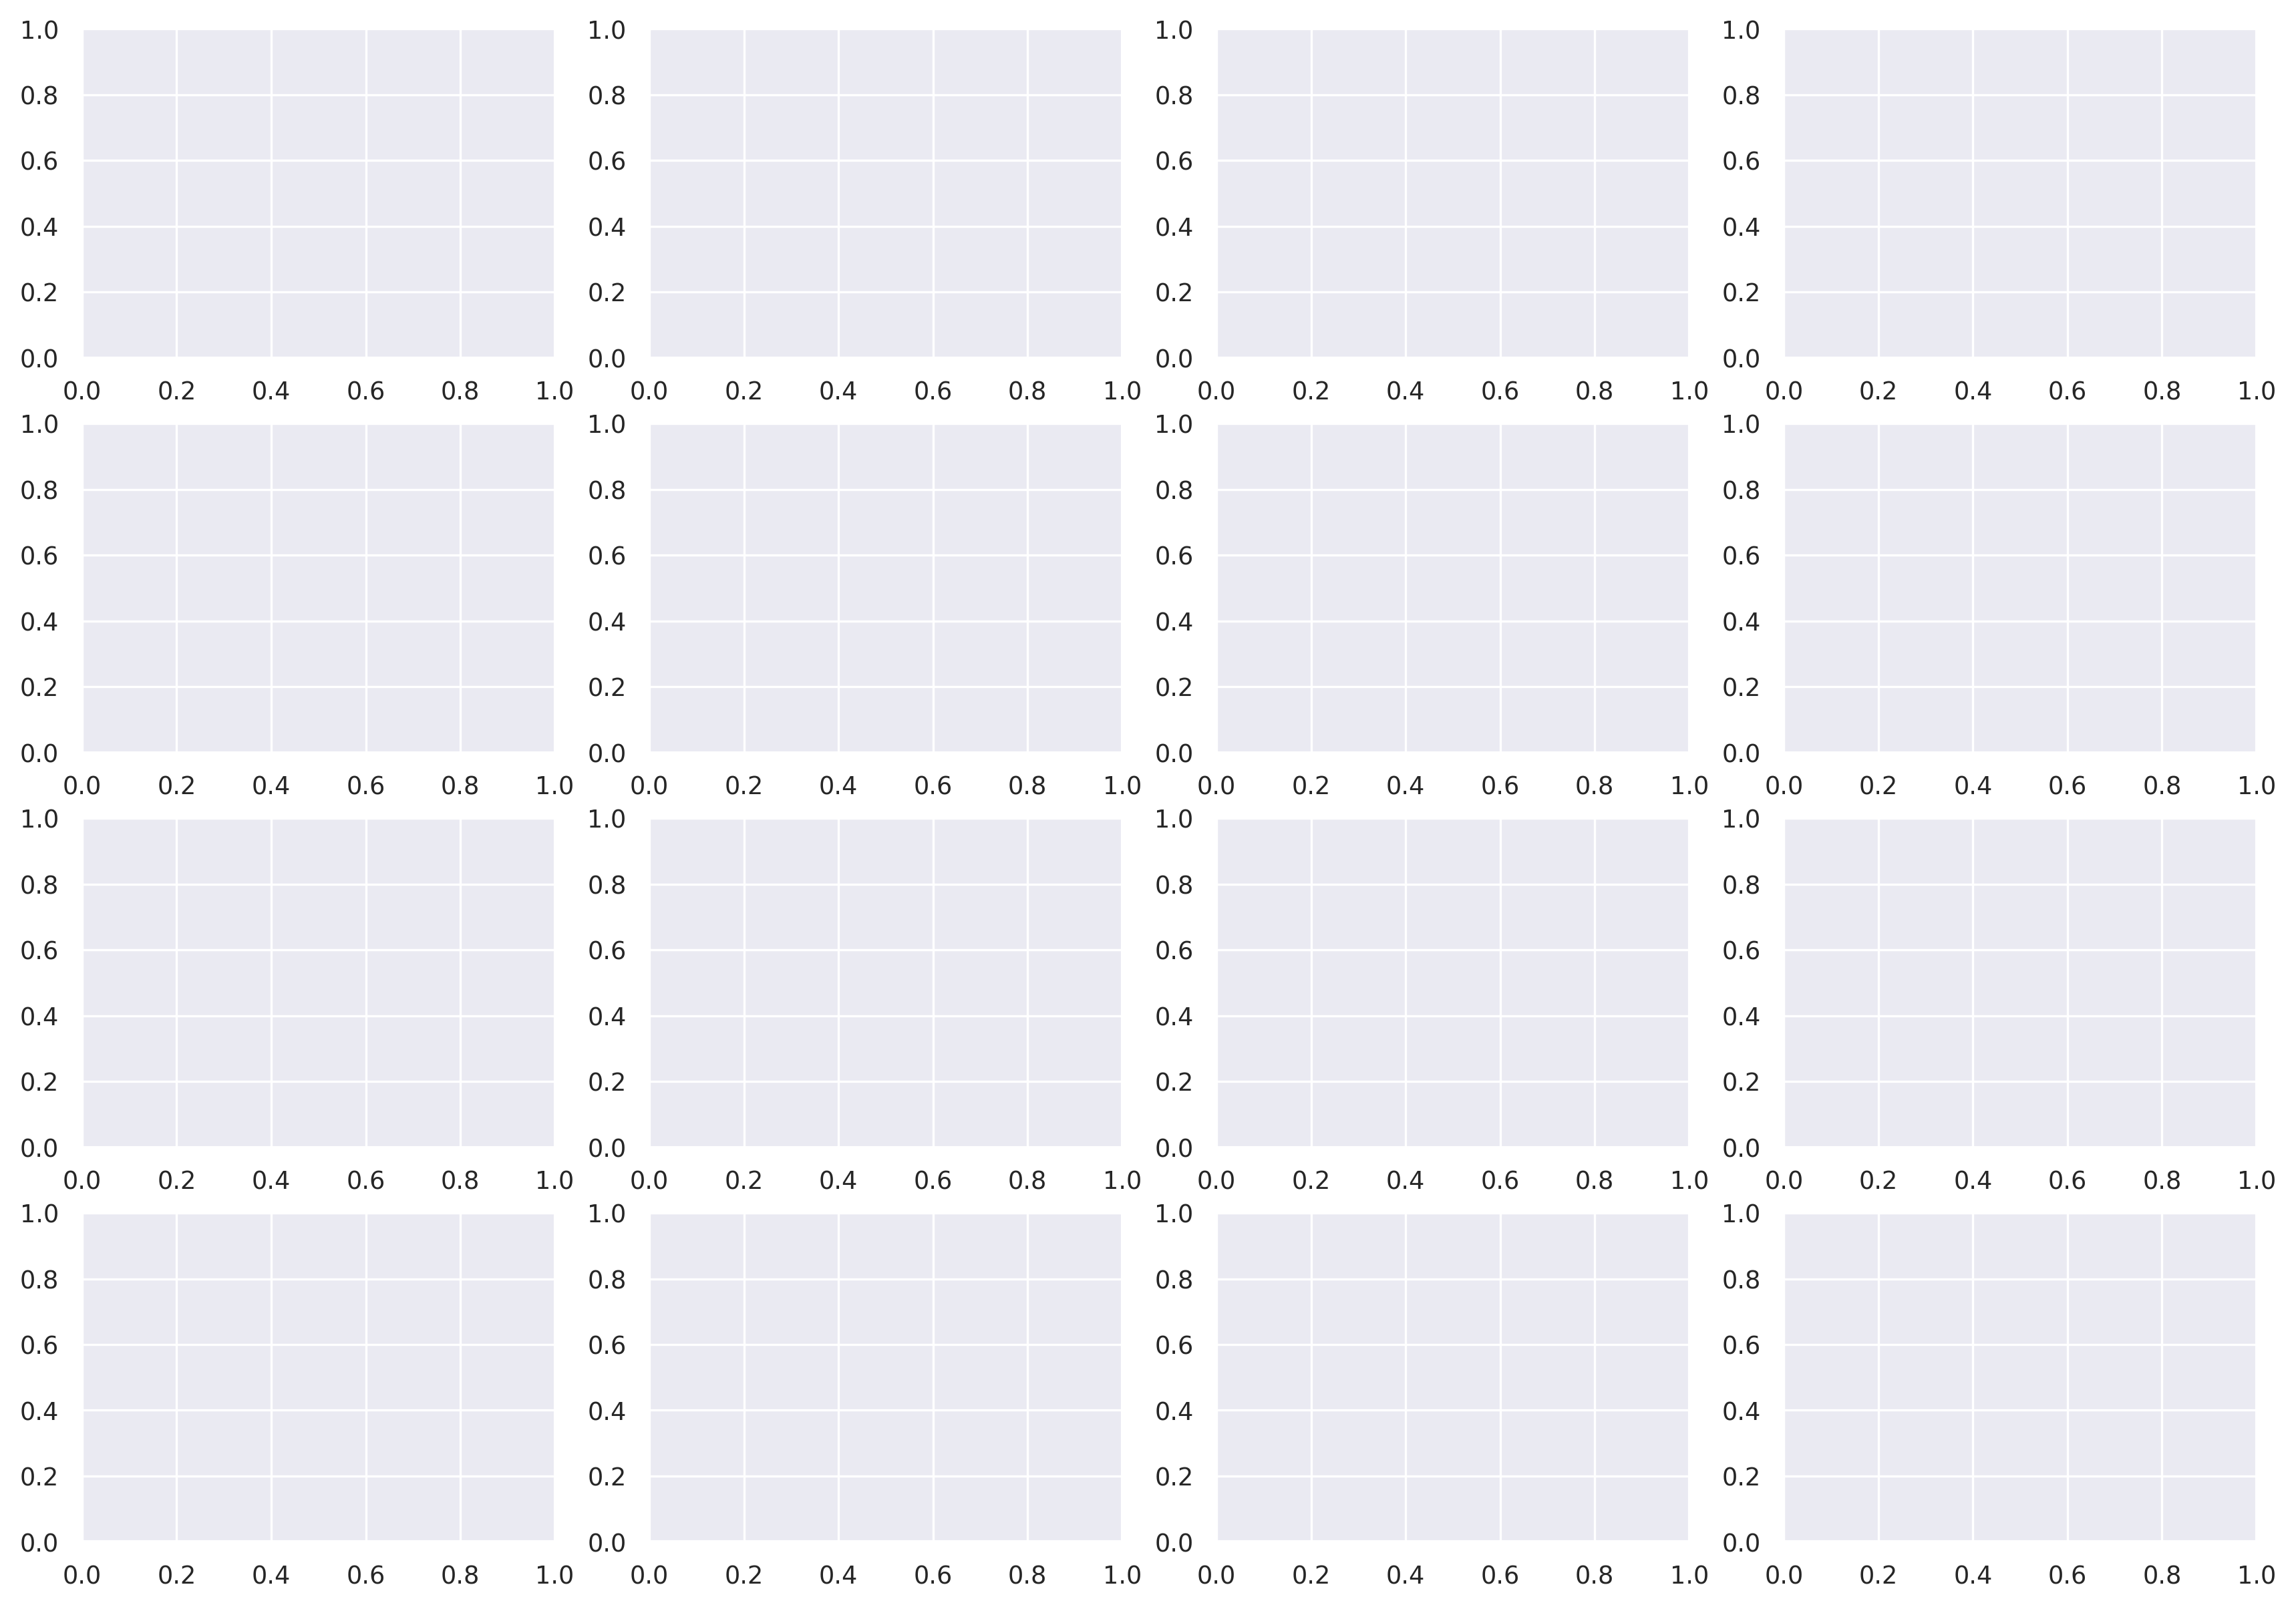

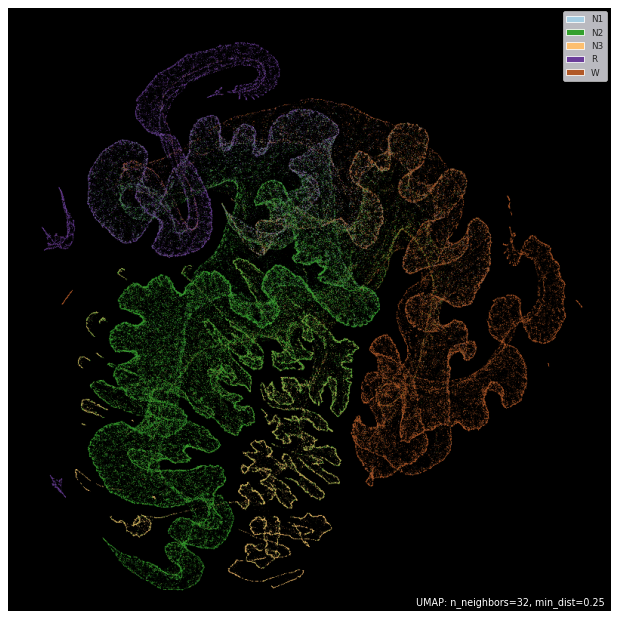

In [11]:
# Create a control-based embedding space
n_neighbors = [32, 64, 128, 256]
min_dist = [0.25, 0.5, 0.75, 0.99]
f, axes = plt.subplots(nrows=len(n_neighbors), ncols=len(min_dist), dpi=300)
for (i, j), (nn, d) in zip(
    itertools.product(range(len(n_neighbors)), range(len(min_dist))),
    itertools.product(n_neighbors, min_dist)
):
    logging.info(f'({i},{j}): knn={nn}, min_dist={d}')
#     print(f"({i}, {j}): {n_knn}")
    logging.info('Creating UMAP object')
    umap_op = umap.UMAP(n_neighbors=nn, n_components=2, min_dist=d, random_state=1337)
    logging.info('Fitting UMAP')
    y_umap = umap_op.fit(X)
    logging.info('Plotting UMAP')
    plt.sca(axes[i, j])
    umap.plot.points(umap_op, labels=l, color_key_cmap='Paired', background='black')
    break
#     y_phate = phate_op.fit_transform(X)
#     title = f"KNN: {n_knn}"
#     scprep.plot.scatter2d(
#         y_phate, 
# #         c=d, 
#         c=l,
#         cmap='Spectral', 
#         ticks=False, 
#         label_prefix='PHATE', 
#         ax=axes[i, j],
#         title=title
#     )
# #     axes[i, j].set_title('subplot 1')
# plt.suptitle(f'Control-based embedding space, n={10}')
# plt.savefig(f'results/phate_control_embedding.png', dpi=300, bbox_inches='tight', pad_inches=0)
#     break
# #     plt.savefig(f"results/phate/phate_narco_{fileid.split('.')[0]}_knn{n_knn:03}_disorder.png", dpi=300, bbox_inches='tight', pad_inches=0)
#     scprep.plot.scatter2d(y_phate, c=l, cmap='Spectral', ticks=False, label_prefix='PHATE')
#     plt.title(title)
# #     plt.savefig(f"results/phate/phate_narco_{fileid.split('.')[0]}_knn{n_knn:03}_stages.png", dpi=300, bbox_inches='tight', pad_inches=0)